<a href="https://colab.research.google.com/github/HafsaTahsin/Niagara/blob/main/CSE425_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -U datasets fsspec

from datasets import load_dataset

dataset = load_dataset("fancyzhx/ag_news")
# Remove the 'label' column from each split
dataset = dataset.remove_columns("label")

# Check the columns in the training set
#print(dataset["train"].column_names)

## no
# View the dataset splits
#print(dataset)

# Access the first example in the training set
#print(dataset["train"][0])

# Access train split with
texts = dataset["train"][:int(len(dataset["train"]) * 0.2)]["text"]
#texts = dataset["train"]["text"]

# If you want a subset:
subset_texts = dataset["train"][:int(len(dataset["train"]) * 0.1)]["text"]

# Pre- processing
# pre trained model bert
!pip install -U sentence-transformers
import re
# Clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

texts = [clean_text(t) for t in texts]

# Step 2: Get Sentence Embeddings
from sentence_transformers import SentenceTransformer
model_sbert = SentenceTransformer("all-MiniLM-L6-v2")
X = model_sbert.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Define the Neural Network Model
# Step 3: Define Autoencoder
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# Step 4: Train Autoencoder
input_size = X.shape[1]
hidden_size = 128
latent_size = 64

model = Autoencoder(input_size, hidden_size, latent_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

inputs = torch.tensor(X, dtype=torch.float32)
epochs = 10

for epoch in range(epochs):
    recon, _ = model(inputs)
    loss = criterion(recon, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 5: DEC Clustering Model
class DEC(nn.Module):
    def __init__(self, encoder, n_clusters, alpha=1.0):
        super(DEC, self).__init__()
        self.encoder = encoder
        self.alpha = alpha
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_size))

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2) / self.alpha)
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q, z

def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

def kl_divergence(p, q):
    return torch.sum(p * torch.log(p / (q + 1e-8)), dim=1).mean()

# Initialize DEC with trained encoder
dec_model = DEC(model.encoder, n_clusters=4)
dec_optimizer = torch.optim.Adam(dec_model.parameters(), lr=0.001)

max_dec_epochs = 20
update_interval = 5
tol = 1e-3
prev_q = None

inputs = inputs  # your input tensor

# Phase 2: DEC Fine-tuning loop
for epoch in range(max_dec_epochs):
    dec_model.train()
    q, z = dec_model(inputs)

    if epoch % update_interval == 0:
      with torch.no_grad():
            p = target_distribution(q)
        #p = target_distribution(q).detach()

      if prev_q is not None:
        delta_label = torch.sum(torch.abs(q - prev_q)) / q.shape[0]
        if delta_label < tol:
          print(f"DEC converged at epoch {epoch}")
          break
      prev_q = q.clone().detach()

    loss = kl_divergence(p, q)

    dec_optimizer.zero_grad()
    loss.backward()
    dec_optimizer.step()

    print(f"DEC Epoch [{epoch+1}/{max_dec_epochs}], Loss: {loss.item():.4f}")

# Step 5: Clustering Evaluation
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#z_np = z.detach().numpy()
with torch.no_grad():
    _, z = model(inputs)
    z_np = z.detach().numpy()

  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Batches:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.2495
Epoch [2/10], Loss: 1.2457
Epoch [3/10], Loss: 1.2415
Epoch [4/10], Loss: 1.2365
Epoch [5/10], Loss: 1.2303
Epoch [6/10], Loss: 1.2225
Epoch [7/10], Loss: 1.2129
Epoch [8/10], Loss: 1.2011
Epoch [9/10], Loss: 1.1869
Epoch [10/10], Loss: 1.1701
DEC Epoch [1/20], Loss: 0.0012
DEC Epoch [2/20], Loss: 0.0007
DEC Epoch [3/20], Loss: 0.0004
DEC Epoch [4/20], Loss: 0.0004
DEC Epoch [5/20], Loss: 0.0004
DEC Epoch [6/20], Loss: 0.0051
DEC Epoch [7/20], Loss: 0.0041
DEC Epoch [8/20], Loss: 0.0030
DEC Epoch [9/20], Loss: 0.0019
DEC Epoch [10/20], Loss: 0.0012
DEC Epoch [11/20], Loss: 0.0156
DEC Epoch [12/20], Loss: 0.0123
DEC Epoch [13/20], Loss: 0.0090
DEC Epoch [14/20], Loss: 0.0062
DEC Epoch [15/20], Loss: 0.0041
DEC Epoch [16/20], Loss: 0.0417
DEC Epoch [17/20], Loss: 0.0337
DEC Epoch [18/20], Loss: 0.0262
DEC Epoch [19/20], Loss: 0.0197
DEC Epoch [20/20], Loss: 0.0146


In [9]:
# KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans_labels = kmeans.fit_predict(z_np)
print("KMeans Silhouette:", silhouette_score(z_np, kmeans_labels))
print("KMeans DB Index:", davies_bouldin_score(z_np, kmeans_labels))
print("KMeans Calinski-Harabasz:", calinski_harabasz_score(z_np, kmeans_labels))

KMeans Silhouette: 0.20539056
KMeans DB Index: 1.4775500780812134
KMeans Calinski-Harabasz: 8686.942


In [10]:
# DBSCAN
# Adjust eps and min_samples based on your data distribution
dbscan = DBSCAN(eps=0.5, min_samples=10) # Example values, you may need to tune these
dbscan_labels = dbscan.fit_predict(z_np)

# Check the number of unique labels found by DBSCAN
unique_labels = len(set(dbscan_labels))

if unique_labels < 2:
    print(f"DBSCAN found only {unique_labels} unique label(s). Cannot compute silhouette score.")
else:
    print("DBSCAN Silhouette:", silhouette_score(z_np, dbscan_labels))
    print("DBSCAN DB Index:", davies_bouldin_score(z_np, dbscan_labels))
    print("DBSCAN Calinski-Harabasz:", calinski_harabasz_score(z_np, dbscan_labels))

DBSCAN found only 1 unique label(s). Cannot compute silhouette score.


In [11]:
# DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(z_np)
print("DBSCAN Silhouette:", silhouette_score(z_np, dbscan_labels))
print("DBSCAN DB Index:", davies_bouldin_score(z_np, dbscan_labels))
print("DBSCAN Calinski-Harabasz:", calinski_harabasz_score(z_np, dbscan_labels))

DBSCAN Silhouette: -0.42019752
DBSCAN DB Index: 1.3350092352628635
DBSCAN Calinski-Harabasz: 6.8713007


In [12]:
# Hierarchical
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_labels = hierarchical.fit_predict(z_np)
print("Hierarchical Silhouette:", silhouette_score(z_np, hierarchical_labels))
print("Hierarchical DB Index:", davies_bouldin_score(z_np, hierarchical_labels))
print("Hierarchical Calinski-Harabasz:", calinski_harabasz_score(z_np, hierarchical_labels))

Hierarchical Silhouette: 0.18062824
Hierarchical DB Index: 1.6108966532737137
Hierarchical Calinski-Harabasz: 6861.468


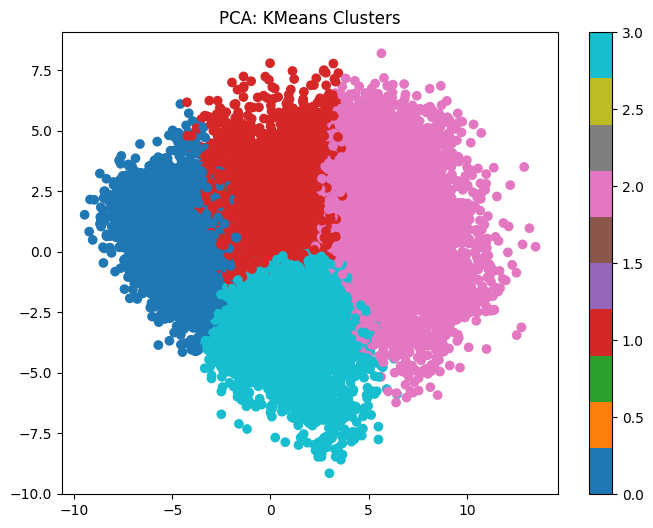

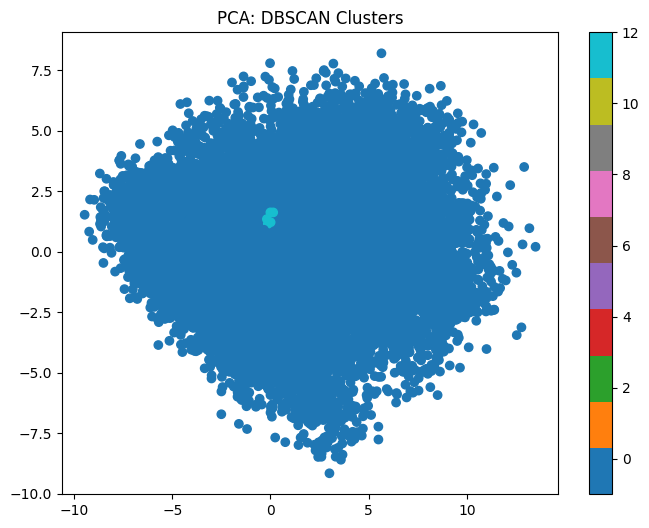

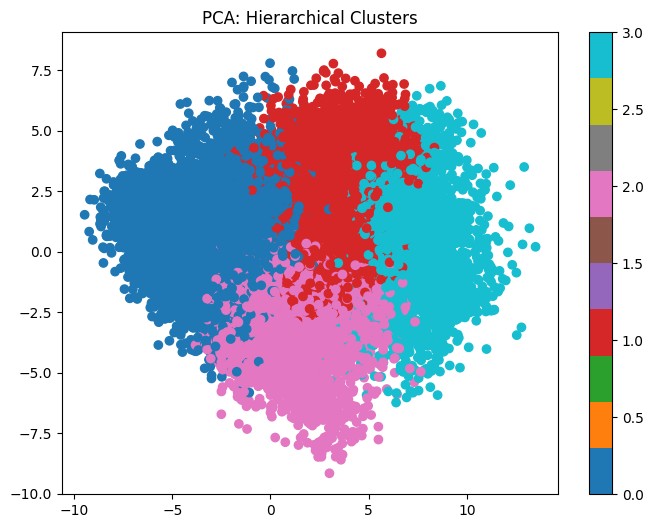

In [14]:
# Vizualization
# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(z_np)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans_labels, cmap='tab10')
plt.title("PCA: KMeans Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='tab10')
plt.title("PCA: DBSCAN Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=hierarchical_labels, cmap='tab10')
plt.title("PCA: Hierarchical Clusters")
plt.colorbar()
plt.show()


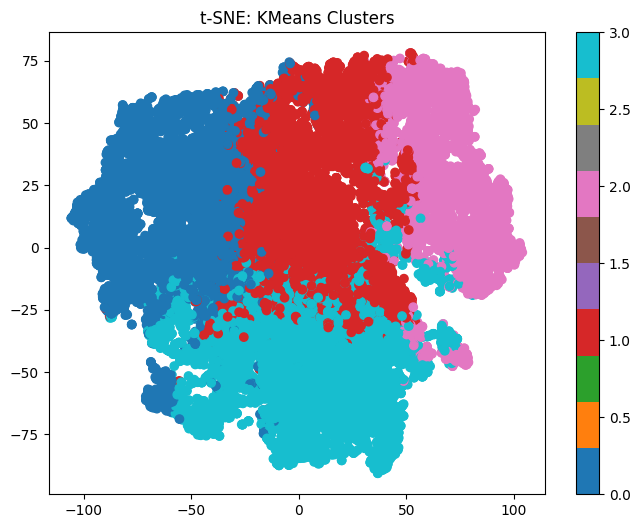

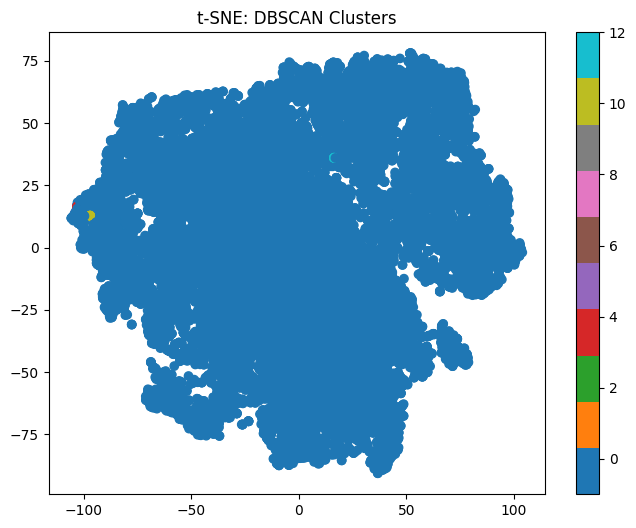

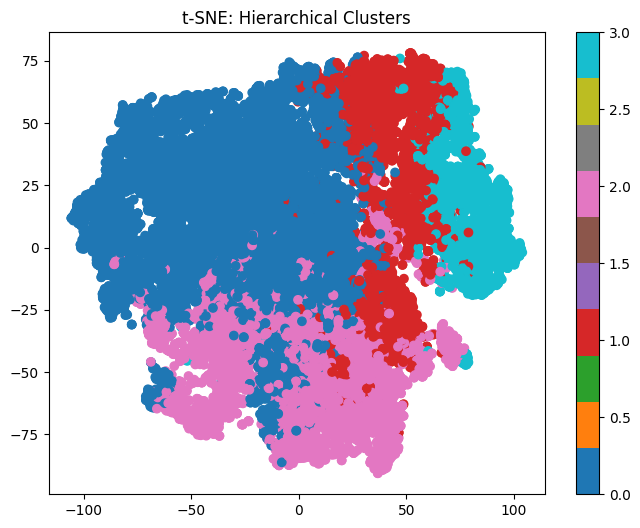

In [15]:

#tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne.fit_transform(z_np)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=kmeans_labels, cmap='tab10')
plt.title("t-SNE: KMeans Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=dbscan_labels, cmap='tab10')
plt.title("t-SNE: DBSCAN Clusters")
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=hierarchical_labels, cmap='tab10')
plt.title("t-SNE: Hierarchical Clusters")
plt.colorbar()
plt.show()

<ipython-input-16-32b94558aaed>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


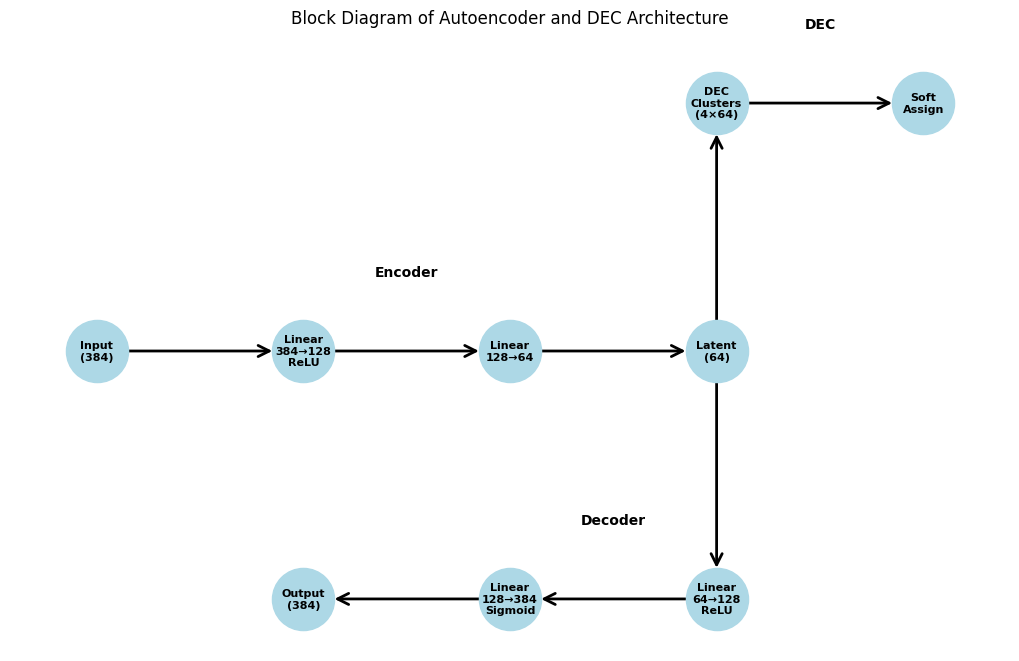

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define nodes (boxes in the diagram)
nodes = [
    "Input\n(384)",
    "Linear\n384→128\nReLU",
    "Linear\n128→64",
    "Latent\n(64)",
    "Linear\n64→128\nReLU",
    "Linear\n128→384\nSigmoid",
    "Output\n(384)",
    "DEC\nClusters\n(4×64)",
    "Soft\nAssign"
]

# Add nodes to the graph
for node in nodes:
    G.add_node(node)

# Define edges (arrows in the diagram)
edges = [
    ("Input\n(384)", "Linear\n384→128\nReLU"),
    ("Linear\n384→128\nReLU", "Linear\n128→64"),
    ("Linear\n128→64", "Latent\n(64)"),
    ("Latent\n(64)", "Linear\n64→128\nReLU"),
    ("Linear\n64→128\nReLU", "Linear\n128→384\nSigmoid"),
    ("Linear\n128→384\nSigmoid", "Output\n(384)"),
    ("Latent\n(64)", "DEC\nClusters\n(4×64)"),
    ("DEC\nClusters\n(4×64)", "Soft\nAssign")
]

# Add edges to the graph
G.add_edges_from(edges)

# Define node positions for a custom layout
pos = {
    "Input\n(384)": (0, 0),
    "Linear\n384→128\nReLU": (1, 0),
    "Linear\n128→64": (2, 0),
    "Latent\n(64)": (3, 0),
    "Linear\n64→128\nReLU": (3, -1),
    "Linear\n128→384\nSigmoid": (2, -1),
    "Output\n(384)": (1, -1),
    "DEC\nClusters\n(4×64)": (3, 1),
    "Soft\nAssign": (4, 1)
}

# Create a figure
plt.figure(figsize=(10, 6))

# Draw the graph
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=2000,
    font_size=8,
    font_weight="bold",
    arrows=True,
    arrowstyle="->",
    arrowsize=20,
    edge_color="black",
    width=2
)

# Add group labels (Encoder, Decoder, DEC)
plt.text(1.5, 0.3, "Encoder", fontsize=10, ha="center", fontweight="bold")
plt.text(2.5, -0.7, "Decoder", fontsize=10, ha="center", fontweight="bold")
plt.text(3.5, 1.3, "DEC", fontsize=10, ha="center", fontweight="bold")

# Set title and adjust layout
plt.title("Block Diagram of Autoencoder and DEC Architecture", fontsize=12, pad=20)
plt.tight_layout()

# Save and show the plot
plt.savefig("dec_model_diagram.png", dpi=300, bbox_inches="tight")
plt.show()